In [142]:
from ipypb import track as tqdm
import torch
import astar
import diffplan
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/carlos/pu/neu502b/env/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


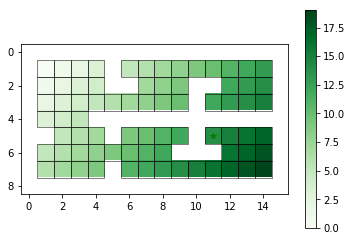

In [409]:
env = diffplan.Grid('''
xxxxxxxxxxxxxxxx
x SS x         x
x SS xx   xx   x
x         x    x
x   xxxxxxxxxxxx
xx   x    xG   x
x        xxx   x
x    x         x
xxxxxxxxxxxxxxxx
''')
_env = diffplan.Grid('''
x xGx
x x x
x   x
xSxxx
x   x
xxx x
xxxGx
xxxxx
''')
# why is spot to left of goal expensive??
_env = diffplan.Grid('''
xxxxxxxx
xS     x
x x    x
x x    x
x x    x
x xxxx x
x     Gx
xxxxxxxx
xxxxxxxx
''')
# why are costs same, even with larger areas? is it fifo vs lifo?
_env = diffplan.Grid('''
xxxxxxxx
x     Gx
xxxx xxx
x  x xxx
x  x xxx
x  x xxx
x  x xxx
x    xxx
x xxxxxx
xSxxxxxx
x xxxxxx
x xxxxxx
x xxxxxx
x xxxxxx
x xxxxxx
x xxxxxx
x xxxxxx
x     Gx
xxxxxxxx
xxxxxxxx
''')
_env = diffplan.Grid('''
xxxxxxxx
x     Gx
xxxx xxx
x  x xxx
x  x xxx
x  x xxx
x  x xxx
x    xxx
x xxxxxx
xSxxxxxx
x xxxxxx
x   xxxx
xxx xxxx
xxx xxxx
xxx xxxx
xxx xxxx
xxx xxxx
x     Gx
xxxxxxxx
xxxxxxxx
''')
_env = diffplan.Grid('''
xxxxxxxxx
x      Gx
x xxx x x
x   x x x
x   x x x
x   x x x
x   x x x
x   x x x
x   x x x
x   x x x
x   x x x
x xxxxx x
xS    x x
xxxxx   x
xxxxxxxxx
''')
_env = diffplan.Grid('''
x   x   xx
x       xx
x   x   xx
x xxxxx xx
x   x   xx
x   x   xx
xSxxxGxxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x xxx xxxx
x     xxxx
''')

heuristic_cost_estimate = astar.compute_manhattan_heuristic(env)
diffplan.plot_grid(env, heuristic_cost_estimate[0])

In [398]:
# We can have different estimates of whats at a depth based on the path we're focused on.
import collections
ct = collections.Counter()
ct2 = collections.Counter()
s, g = env.states_to_idx[1, 4], env.states_to_idx[4, 7]
s, g = env.states_to_idx[2, 7], env.states_to_idx[4, 9]
for seed in np.arange(500, 1500):
#for seed in np.arange(530, 535):
    random.seed(seed)
    d = astar.a_star_cost(env, s, g, heuristic_cost_estimate, return_path=True, queue='lifo')
    if sum(c[-1] for c in ct.items()) < 10:
        print(seed, d['fmatch_count_remaining']+d['nodes_visited'], d['fmatch_count_remaining'], d['nodes_visited'], d['path'][0])
    ct[d['fmatch_count_remaining']+d['nodes_visited']] += 1
    ct2[d['nodes_visited']] += 1

print(ct)
for k, c in sorted(ct2.items()):
    print(k, c)

KeyError: (4, 9)

In [410]:
next_state = np.array([
    [env.step(s, a)[0] for a in env.actions]
    for s in env.states
])

cost = np.zeros((len(env.states), len(env.states)))
a_star_distance = np.zeros((len(env.states), len(env.states)))
data = {}
for s in tqdm(env.states):
    for g in env.states:
        samples = 20
        ds = [
            astar.a_star_cost(env, s, g, heuristic_cost_estimate, next_state=next_state)
            for _ in range(samples)
        ]
        if ds[0] is None:
            print(s, g, ds)
            assert False
        cost[s, g] = 1.*sum(d['nodes_visited'] for d in ds)/samples
        a_star_distance[s, g] = ds[0]['final_score']
        ds2 = [
            astar.a_star_cost(env, s, g, heuristic_cost_estimate, next_state=next_state, queue='fifo')
            for _ in range(samples)
        ]
        data[s, g] = ds, ds2

 [████████████████████████████████████████████████████████████] 74/74 [01:05<00:01, 0.88s/it]

In [383]:
#s, g = 0, 55
#ds, ds2 = data[s, g]
for s in env.states:
    for g in env.states:
        ds, ds2 = data[s, g]
        tot = ds2[0]['nodes_visited'] + ds2[0]['fmatch_count_remaining']
        for d in ds+ds2:
            assert tot==d['nodes_visited'] + d['fmatch_count_remaining'], (s, g, d)
            assert tot==d['nodes_visited_final'], (s, g, d)
print('hi')

hi


Text(0.5, 1.0, 'A* cost')

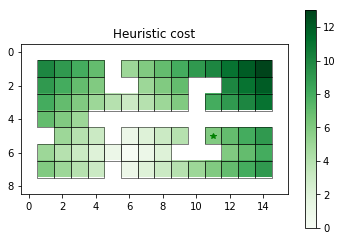

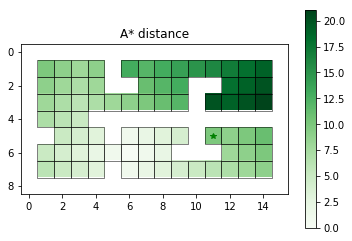

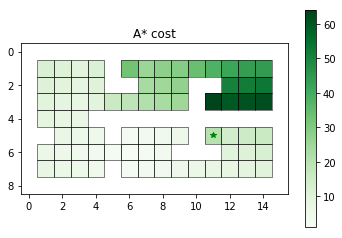

In [411]:
diffplan.plot_grid(env, heuristic_cost_estimate[55])
plt.title('Heuristic cost')
diffplan.plot_grid(env, a_star_distance[55])
plt.title('A* distance')
diffplan.plot_grid(env, cost[55])
plt.title('A* cost')

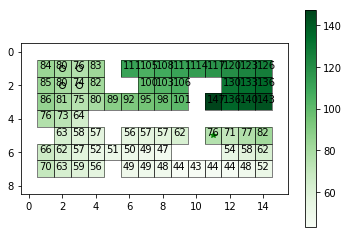

In [412]:
c = a_star_distance + cost
for g in env.goal_set:
    val = c[env.start_states].mean(0) + c[:, env.states_to_idx[g]]
    diffplan.plot_grid(env, val, labels=list(map(str, np.round(val).astype(np.int))), goal_set={g}, start_states=env.start_states)


seed 107143368
49 42.14150619506836
99 42.137474060058594
99 Reset optimizer state
149 42.135677337646484
199 42.135677337646484
199 Reset optimizer state
249 42.135677337646484
299 42.135677337646484
299 Reset optimizer state


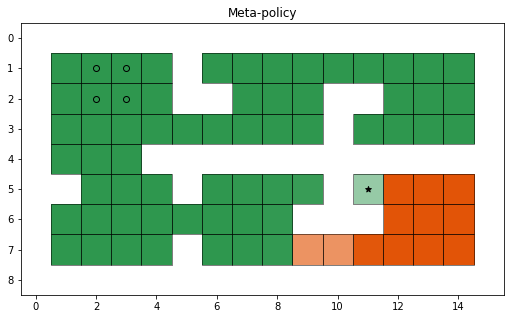

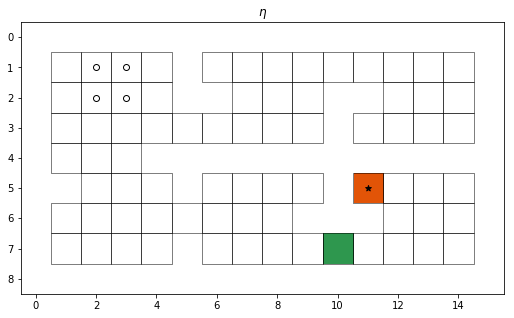

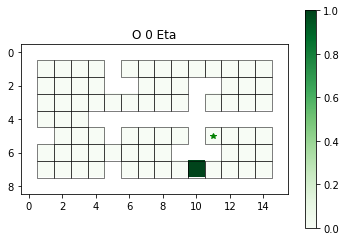

In [413]:
# 38.50, door to last room
# 468419143, 37.41 with 800, lr=0.3, num_options=3
# 374981103, 35.74 with 300, lr=0.5, num_options=4
# 6811343 37.18 with reset=100, grad_steps=300, lr=0.5, num_options=3
d=diffplan.option_learner(env, reset=100,search_cost=torch.tensor(a_star_distance+cost).float(), progress=50, grad_steps=300, lr=0.5, num_options=1, add_goal_options=True, goal_uniform_random=True)


seed 240442862
9 37.7706413269043
19 32.210411071777344
29 30.8753662109375
39 30.257587432861328
49 29.94345474243164
59 29.932174682617188
69 29.930927276611328
79 29.93061065673828
89 29.930500030517578
99 29.930438995361328
99 Reset optimizer state
109 29.929630279541016
119 29.92963218688965
129 29.929630279541016
139 29.929628372192383
149 29.92962646484375
159 29.92962646484375
169 29.92962646484375
179 29.92962646484375
189 29.92962646484375
199 29.92962646484375
199 Reset optimizer state
209 29.92962646484375
219 29.92962646484375
229 29.92962646484375
239 29.92962646484375
249 29.92962646484375
259 29.92962646484375
269 29.92962646484375
279 29.92962646484375
289 29.92962646484375
299 29.92962646484375
299 Reset optimizer state


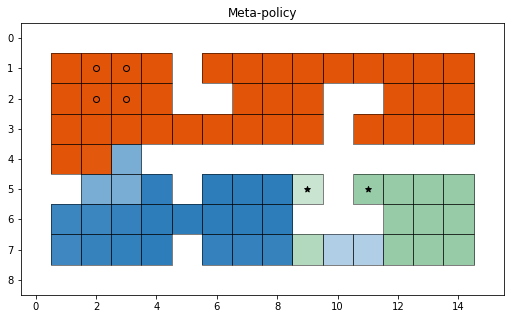

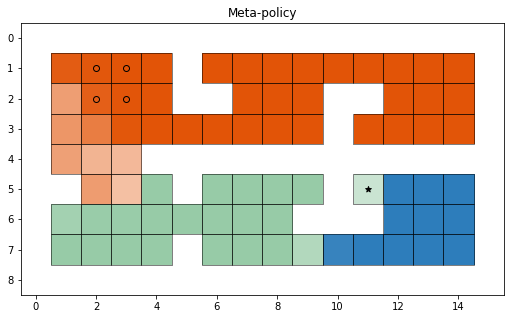

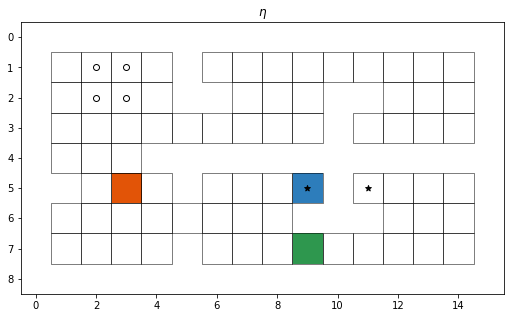

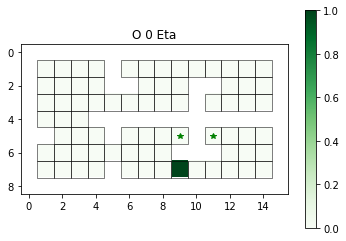

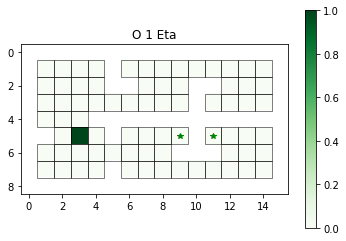

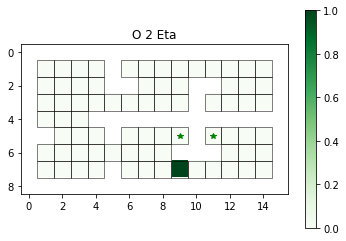

In [418]:
# HACK need more options than goals! otherwise you burn your options trying to learn goals...
env2goal = copy.copy(env)
#env2goal.goal_set = {(5, 11), (5, 9), (1, 6), (3, 11)}
env2goal.goal_set = {(5, 11), (5, 9)}
d=diffplan.option_learner(env2goal, reset=100,search_cost=torch.tensor(a_star_distance+cost).float(), progress=10, grad_steps=200, lr=0.4, num_options=3, goal_uniform_random=True, show_all_metapolicies=True, add_goal_options=True)


seed 229794027
9 10.1654052734375
19 9.91441535949707
29 9.816389083862305
39 9.776426315307617
49 9.771034240722656
59 9.77052116394043
69 9.770410537719727
79 9.770362854003906
89 9.770329475402832
99 9.77030086517334
99 Reset optimizer state
109 9.769798278808594
119 9.769765853881836
129 9.76976203918457
139 9.769760131835938
149 9.769760131835938
159 9.769758224487305
169 9.769759178161621
179 9.769758224487305
189 9.769758224487305
199 9.769758224487305
199 Reset optimizer state


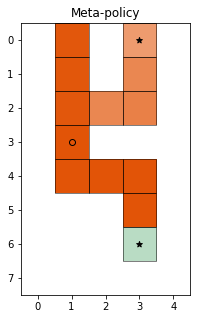

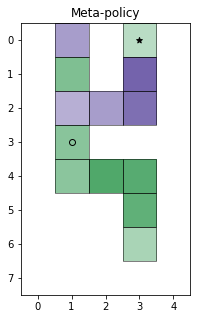

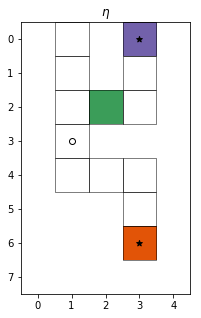

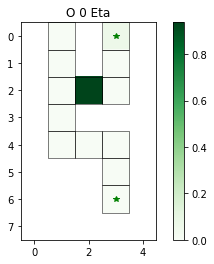

In [334]:
# 482474172 9.77045
d=diffplan.option_learner(env, reset=100,search_cost=torch.tensor(cost).float(), progress=10, grad_steps=200, lr=0.2, num_options=1, goal_uniform_random=True, show_all_metapolicies=True, add_goal_options=True)